In [5]:
import numpy as np
import random

In [20]:
# generate a sequence of random number in [0, n_features)
def generate_sequence(length, n_features):
    return [random.randint(0, n_features - 1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [25]:
sequence = generate_sequence(25, 100)
print(sequence)

[96, 35, 85, 73, 56, 22, 37, 25, 66, 75, 6, 46, 77, 84, 77, 53, 38, 85, 0, 61, 37, 55, 31, 0, 89]


In [26]:
encoded = one_hot_encode(sequence, 100)
print(encoded)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [27]:
decoded = one_hot_decode(encoded)
print(decoded)

[96, 35, 85, 73, 56, 22, 37, 25, 66, 75, 6, 46, 77, 84, 77, 53, 38, 85, 0, 61, 37, 55, 31, 0, 89]


In [28]:
# 25個の時系列データ（各データの特徴量は100次元ベクトル）
encoded.shape

(25, 100)

In [29]:
# LSTMへ入力できるように (samples, time steps, features) の3Dテンソルに変換
X = encoded.reshape(1, 25, 100)

In [30]:
X.shape

(1, 25, 100)

In [32]:
y = encoded[1, :]
y.shape

(100,)

In [33]:
# generate one example for an lstm
def generate_example(length, n_features, out_index):
    # generate sequence
    sequence = generate_sequence(length, n_features)
    # one hot encode
    encoded = one_hot_encode(sequence, n_features)
    # reshape sequence to be 3D
    X = encoded.reshape((1, length, n_features))
    # select output
    y = encoded[out_index].reshape(1, n_features)
    return X, y

In [45]:
# 訓練用のデータを1サンプルだけ生成
# ランダムに生成した系列の2番目を正解とする
X, y = generate_example(25, 100, 2)
print(X.shape)
print(y.shape)
print(one_hot_decode(X[0, :]))
print(one_hot_decode(y))

(1, 25, 100)
(1, 100)
[27, 75, 79, 37, 99, 88, 42, 98, 95, 53, 25, 48, 35, 53, 39, 27, 25, 79, 78, 91, 46, 72, 35, 53, 86]
[79]


In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# define model
length = 5  # 系列長
n_features = 10  # 特徴量の次元
out_index = 2  # 入力系列中で出力したい値のインデックス
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25)                3600      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
Total params: 3,860
Trainable params: 3,860
Non-trainable params: 0
_________________________________________________________________
None


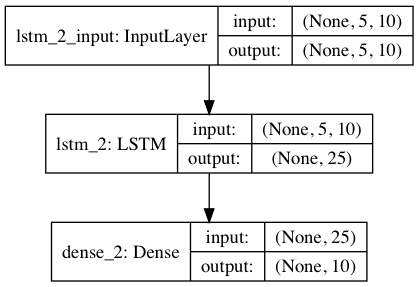

In [70]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

In [71]:
# fit model
loss = []
for i in range(10000):
    # 1つだけサンプル生成して1エポック学習
    X, y = generate_example(length, n_features, out_index)
    h = model.fit(X, y, epochs=1, verbose=0)
    loss.append(h.history['loss'][0])

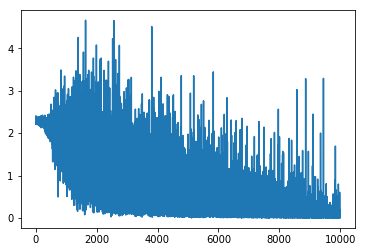

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss)

In [76]:
# TODO: 1サンプルずつではなくまとめて生成してミニバッチ学習したらどうなる？
train_data = []
train_label = []
for i in range(10000):
    X, y = generate_example(length, n_features, out_index)
    train_data.append(X)
    train_label.append(y)
train_data = np.array(train_data)
train_label = np.array(train_label)
train_data = train_data.reshape(10000, length, n_features)
train_label = train_label.reshape(10000, n_features)

# create new model
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

hist = model.fit(train_data, train_label, batch_size=100, epochs=20, verbose=2)

Epoch 1/20
2s - loss: 2.2354 - acc: 0.2554
Epoch 2/20
2s - loss: 1.9350 - acc: 0.3484
Epoch 3/20
2s - loss: 1.4394 - acc: 0.4702
Epoch 4/20
2s - loss: 0.9583 - acc: 0.6595
Epoch 5/20
2s - loss: 0.7017 - acc: 0.7745
Epoch 6/20
2s - loss: 0.5223 - acc: 0.8535
Epoch 7/20
2s - loss: 0.3804 - acc: 0.9058
Epoch 8/20
2s - loss: 0.2697 - acc: 0.9405
Epoch 9/20
2s - loss: 0.1866 - acc: 0.9675
Epoch 10/20
2s - loss: 0.1286 - acc: 0.9846
Epoch 11/20
2s - loss: 0.0889 - acc: 0.9927
Epoch 12/20
2s - loss: 0.0627 - acc: 0.9968
Epoch 13/20
2s - loss: 0.0452 - acc: 0.9981
Epoch 14/20
2s - loss: 0.0333 - acc: 0.9994
Epoch 15/20
2s - loss: 0.0253 - acc: 0.9998
Epoch 16/20
2s - loss: 0.0196 - acc: 0.9999
Epoch 17/20
2s - loss: 0.0156 - acc: 1.0000
Epoch 18/20
2s - loss: 0.0126 - acc: 0.9999
Epoch 19/20
2s - loss: 0.0104 - acc: 1.0000
Epoch 20/20
2s - loss: 0.0086 - acc: 1.0000


In [68]:
print(train_data.shape)
print(train_label.shape)

(10000, 5, 10)
(10000, 10)


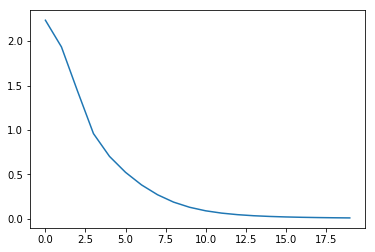

In [82]:
plt.plot(hist.history['loss'])

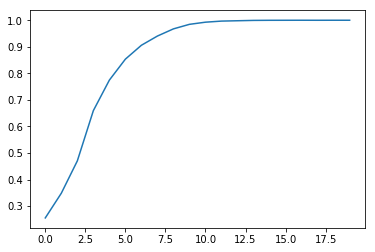

In [84]:
plt.plot(hist.history['acc'])

In [85]:
# evaluate model
correct = 0
for i in range(100):
    X, y = generate_example(length, n_features, out_index)
    yhat = model.predict(X)
    if one_hot_decode(yhat) == one_hot_decode(y):
        correct += 1
print('Accuracy: %f' % ((correct / 100) * 100.0))

Accuracy: 100.000000


In [87]:
# prediction on new data
X, y = generate_example(length, n_features, out_index)
yhat = model.predict(X)
print('Sequence: %s' % [one_hot_decode(x) for x in X])
print('Expected: %s' % one_hot_decode(y))
print('Predicted: %s' % one_hot_decode(yhat))

Sequence: [[8, 2, 7, 9, 7]]
Expected: [7]
Predicted: [7]


In [88]:
# TODO: 6.9 Extensionsの実験をする